# Splitting autocorrelated data

We'll make some autocorrelated data and then try learning on it, with and without leakage.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

well_logs = 'https://geocomp.s3.amazonaws.com/data/Colorado_wells.csv.zip'
df = pd.read_csv(well_logs, index_col=0)
df.describe()

,Well,Depth,CAL,GR,SP,RES,NPHI,RHOB,DT
count,396571.000000,396571.000000,390209.000000,386045.000000,396241.000000,394789.000000,388661.000000,389977.000000,392578.000000
mean,47.199818,2006.378918,8.173011,115.664645,-26.063578,8.718017,1.712450,2.541765,84.399025
std,28.037796,286.510339,0.556594,35.948221,184.768790,37.503786,7.263193,2.403070,11.065214
min,1.000000,1321.917600,2.980800,3.090000,-848.849399,0.133100,-1.027000,-811.401500,-2.996000
25%,21.000000,1778.508000,7.836000,101.417700,-171.557200,2.751800,0.212600,2.519700,78.257500
50%,47.000000,1982.724000,8.010500,113.061400,16.230400,3.733300,0.262800,2.559400,86.151100
75%,71.000000,2200.198800,8.410800,126.983600,123.327100,6.351000,0.297200,2.589000,92.165875
max,96.000000,2810.560800,14.785900,2160.508497,662.844700,2000.000000,88.737900,3.033000,144.353400


In [2]:
df = df.dropna()

In [3]:
df = df[df['DT'] > 50]

In [4]:
df['log_RES'] = np.log10(df['RES'])

In [5]:
df.head()

,Well,Depth,CAL,GR,SP,RES,NPHI,RHOB,DT,log_RES
0,1.0,1681.5816,8.5207,114.6138,58.7831,7.4246,0.1960,2.5989,76.6762,0.870673
1,1.0,1681.7340,8.5652,113.3488,58.7735,7.4886,0.1916,2.5859,76.5024,0.874401
2,1.0,1681.8864,8.5683,119.9841,59.0329,7.5989,0.1851,2.5830,75.9684,0.880751
3,1.0,1682.0388,8.5203,121.0104,59.2197,7.7094,0.1894,2.5882,75.7419,0.887021
4,1.0,1682.1912,8.4563,118.1462,59.9868,7.7865,0.1956,2.5906,76.5455,0.891342


In [6]:
len(df['Well'].unique())

74

## Reduce dataset size and make holdout

The effect I want to illustrate will show up more obviously in a relatively small dataset. Let's start with only 10 wells, but we can change it later and run again.

In [312]:
df_ = df[df['Well'] >= 80]
test = df[df['Well'] < 80]

In [313]:
df_['Well'].unique()

array([80., 81., 83., 84., 85., 86., 87., 88., 89., 90., 93., 94., 95.,
       96.])

## Split naively

In [314]:
from sklearn.model_selection import train_test_split

features = ['GR', 'log_RES', 'NPHI', 'RHOB']

X = df_[features].values
y = df_['DT'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.6, random_state=42)

X_test = test[features].values
y_test = test['DT'].values

In [315]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression

pipe = make_pipeline(StandardScaler(), Ridge())

In [316]:
from sklearn.metrics import mean_squared_error, r2_score

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred)), r2_score(y_val, y_pred)

(3.6657938724978063, 0.8314440956000599)

Let's look at the performance on the holdout:

In [317]:
y_pred_test = pipe.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R2:  ", r2_score(y_test, y_pred_test))

RMSE: 104.5315166606079
R2:   -85.9602479578131


## Split by well

Note that wells can still be spatially correlated, we don't have location info in this dataset.

In [318]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=42)
(train_idx, val_idx), = gss.split(X, y, df_['Well'])

In [319]:
X_train = df[features].values[train_idx]
X_val = df[features].values[val_idx]

y_train = df['DT'].values[train_idx]
y_val = df['DT'].values[val_idx]

In [320]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred)), r2_score(y_val, y_pred)

(7.776456083302048, 0.6747586074718034)

In [321]:
y_pred_test_correct = pipe.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test_correct)))
print("R2:  ", r2_score(y_test, y_pred_test_correct))

RMSE: 5.670893146490848
R2:   0.7440652868570408


## Compare

How do they compare qualitatively?

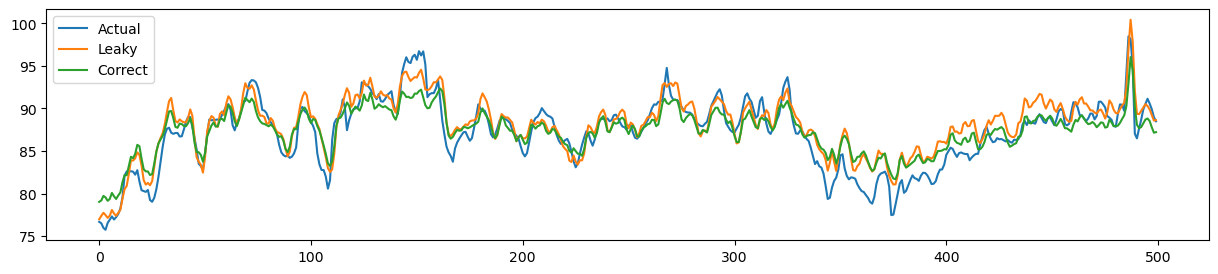

In [322]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(y_test[:500], label='Actual')
ax.plot(y_pred_test[:500], label='Leaky')
ax.plot(y_pred_test_correct[:500], label='Correct')
ax.legend()